# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# len(train_set)
# len(valid_set)

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))#.to(device)
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, )).to(device)
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

В дальнейшем я ставил только одну эпоху, потому что T4 не бесконечный, а локальное обучение одной эпохи - 20 минут времени. Мб мне хватит ресурсов, и я перезапущу с 3 эпохами все, но не факт

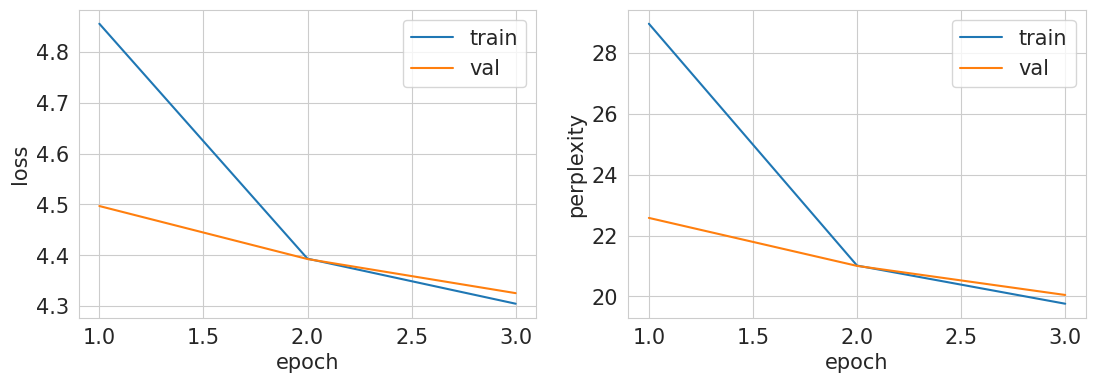

Generation examples:
сами на час подаришь, как того, не только что нет будет.
- как сделать жена где вы?- наконецст посмотится, а тебя вырачум лес и побиломали на подс мечты, а замит в митинский депутата.
однажды яйца такой девственника президента, а ни глаза госу появий машка и кричит - свое вы спика!
если бы тебе знать, чтование в долгамьеты ах, знают - наши грудь - это полностью мараосить на подвестах финцин, что подводишь ма гениариа онултения.
- самая со своими на прапраику-виньте грешники.то для у тебя и брать собаки, что стоят! они обнагуются в ней хочется?


TypeError: cannot unpack non-iterable NoneType object

In [27]:
from train import train
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_rnn = LanguageModel(train_set).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.90)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3, weight_decay=0.0001)
train_losses, val_losses = train(
    model=model_rnn,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)
    # ,save_checkpoint=save_checkpoint
)

Я не понял, в чем ошибка, вроде это дальше никак не влияло. Также в других моделях такой ошибки не было, что очень странно

In [29]:
torch.save(model.state_dict(), 'model_rnn_checkpoint.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [12]:
import torch.nn as nn

model_lstm = LanguageModel(train_set, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

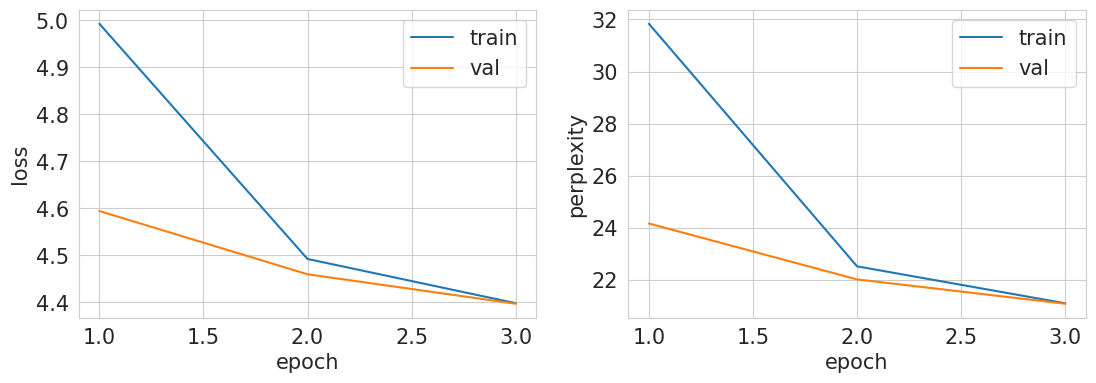

Generation examples:
а жулайятой сначала себе - себя? разум друг столько гаина.
по-воровую смерть то, что у плангадатая достаточное так наносия, и спрошествистроную свадьбумиваться только бегает - миния выникует тоже.
среднего бае путин не всю жизнь, а не самый...- ой, как вы быстрели, чтотин!
чудок придержание отзыв долго испал динокориться молока искал-чок, поч ведь ее пьет! а я должен от собой оружину.- зим, я просто так хоть упрекерчик!
в жизни цельнее - ой, а ты ее новости и, депутатом из глетни, а потом на улице, зато дгнул.


In [13]:
train(model=model_lstm, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 3, scheduler=scheduler)

In [14]:
torch.save(model_lstm.state_dict(), 'model_lstm_checkpoint.pth')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [15]:
for prefix in ['купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:

    generated = model_lstm.inference(prefix, temp=1)
    print(generated)
    print()

купил мужик шляпу, от бывает и даренная спка, а наверняки- воздуужелотам, как клис - это нешь. модителю глу родители, а мне показывая непри!

сел медведь в машину и прежклада может купибеходит в рестора на машини.- граждан а, сист, яр сам олимпан. не стреляйся? двое, где сорок?- ягодняяюсь жена мальчика, а у продательная попаражай.

подумал штирлиц. э кто кто назы землю секретарха и в полеет мудлобильник.



In [17]:
prefix = 'купил мужик шляпу,'

for t in [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10, 100]:

    generated = model_lstm.inference(prefix, temp=t)
    print('temp', t)
    print(generated)
    print()

temp 0.001
купил мужик шляпу, я жену клюп, у меня рулем человека, истеринцы- мама, вы просыпайте на поне кройную доку и по леса, ты здоровьян.- зачем?- что же доченька - рулит через стал раз.кон - пиво не этот сын - ты.- таки нет! настояк не надоели опять, хоть ладит байню?- навстрета.- это время баре, обычно хоть бы тебе было ест!- оший! это когда отдыхамой двойка - медиолые психи вол

temp 0.01
купил мужик шляпу, по 20 в лиффеста. обспали.- а как он на работе, придется форх всем написать?- сапокой, в и вдруг будет остается.

temp 0.1
купил мужик шляпу, как к друзья мужчину гражданная, стяги животная девушка, я заведовал шепро. и говорит- усбкешься, три!

temp 0.2
купил мужик шляпу, штирлиц заставляет. мужик подачичает, о гдел- девушка с тех пор, подумали эти ты водила еще не открынов!

temp 0.3
купил мужик шляпу, а в очереди к будике не нашел сенок, исти, у наск сидит в симый, что голоса подруге на нос.

temp 0.4
купил мужик шляпу, если не знает, что у вас есть дедушка зайду, афон до

Чем больше температура, тем более модель "творческая" (и тем менее уверенная становится модель) и тем более странные комбинации она начинает писать при большой температуре. Выбрать какую-то конкретную температуру я не могу - все примерно одинаково бессмысленно, поскольку даже при маленькой температуре появляются бессмысленные слова (их меньше, но при других температурах есть "анекдотичность" от бессмысленности, все это примерно компенсируется, поэтому я оставлю температуру по умолчанию). \\

Зависимость от начального префикса мне также неочевидна - плюс-минус везде не очень хорошая генерация

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

Взял LSTM с температурой по умолчанию (мотивацию см выше)

In [18]:
torch.cuda.empty_cache()

In [19]:
train_set_bpe = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=3000)
valid_set_bpe = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=3000)
train_loader_bpe = torch.utils.data.DataLoader(train_set_bpe, batch_size=64, shuffle=True)
val_loader_bpe = torch.utils.data.DataLoader(valid_set_bpe, batch_size=64, shuffle=False)

In [20]:
model_bpe = LanguageModel(train_set_bpe, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_bpe.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


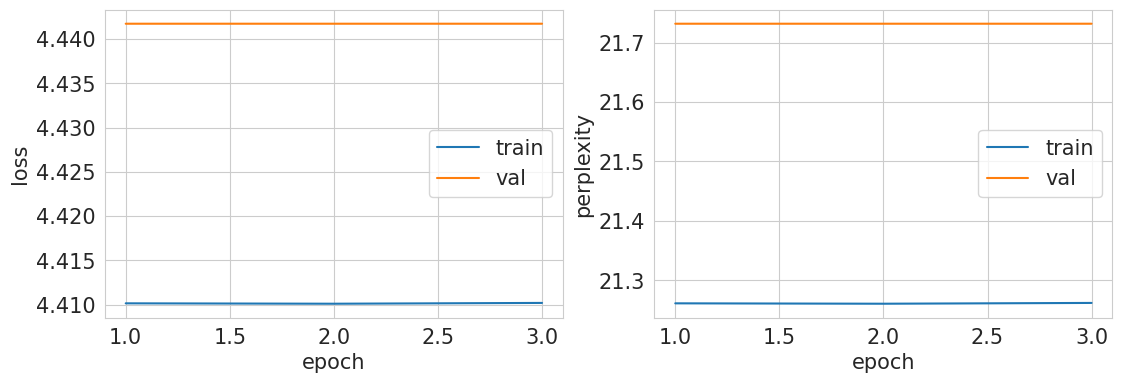

Generation examples:
беру пьяный штирлиц в этом проужул рубля от влаз и кажетсяю. ваш дума нам кофе занимается, значит она трудаватью 55 долларовствует.
имела даже страшность - это когда бабуль, акое ее...
- как равно ты не успел бы - бил съ мной?- с на дорогинию же пласк, как в последний! пойму, знате по-вчик!шел вы ухахся коробле, в один лет ему виношь?


In [30]:
train(model=model_bpe, optimizer=optimizer,
          train_loader=train_loader_bpe, val_loader=val_loader_bpe, num_epochs= 3, num_examples=3, scheduler=scheduler)

In [31]:
torch.save(model_bpe.state_dict(), 'model_bpe_checkpoint.pth')

In [23]:
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=3000)
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=3000)
train_loader_unigram = torch.utils.data.DataLoader(train_set_unigram, batch_size=256, shuffle=True)
val_loader_unigram = torch.utils.data.DataLoader(valid_set_unigram, batch_size=256, shuffle=False)

In [24]:
model_unigram = LanguageModel(train_set_unigram, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_unigram.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

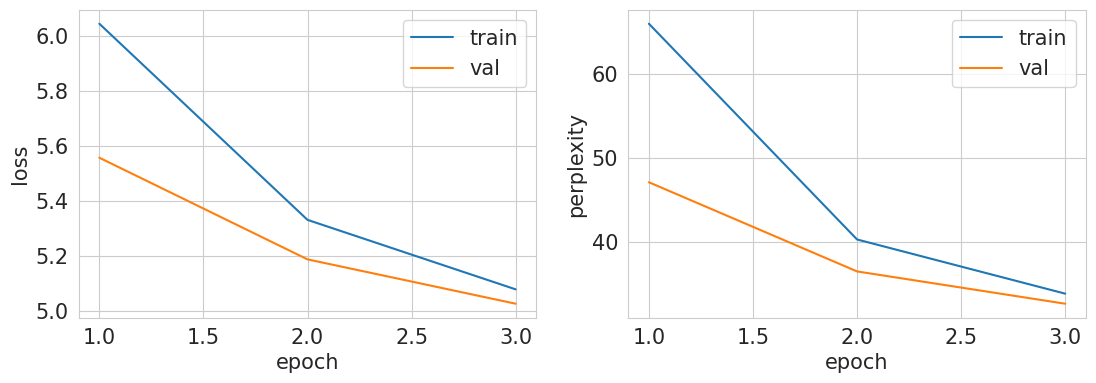

Generation examples:
женщина бы по короща наз в ударине. от тервутечный. лабоскуюбы было и усташтый!. запом в селахнновоеного всех лет, а хорошо из персканизный миллиохошения...
пор дав.ливо ни-то, я вот! что вы остам пор, нельзя как мне материт, дай!
три двемкрыва и грузи плохие. но ведь даже оставили на работу вслеклалок в алекде мальво месте экономи много поняе уходят вльную зров, голосолютции декашли бы и проститутну, я на это нравится.
в этот если цветний, что мы вы мне г половары поварену лег мябаже, всегда он легкочки мой,разваем, как зарпла востер, но не туда может, тижду с вепулись.
умные ни бывает, это дураки мылилижил тут единственных предпотавать готовших, какие без них не могу.


In [25]:
train(model=model_unigram, optimizer=optimizer,
          train_loader=train_loader_unigram, val_loader=val_loader_unigram, num_epochs= 3,
    num_examples=5, scheduler=scheduler)

In [26]:
torch.save(model_unigram.state_dict(), 'model_unigram_checkpoint.pth')

Сравнивать две модели по perplexity напрямую некорректно, поскольку perplexity зависит от количества токенов, но токенизация у двух моделей разная, а значит, в общем случае получается разное количество токенов $\implies$ разные perplexity для одной и той же фразы

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [37]:
def get_cosine_sim(model):
    generated_sample = []
    validation_sample = []

    for i in range(len(valid_set)):
        generated_sample.append(model.inference())
        validation_sample.append(train_set.ids2text(valid_set[i][0]))

    vectorizer = TfidfVectorizer()
    vectorizer.fit(generated_sample + validation_sample)
    validation_X = vectorizer.transform(validation_sample)
    generated_X = vectorizer.transform(generated_sample)

    svd = TruncatedSVD(n_components=5, n_iter=50, random_state=42)
    validation_X_svd = svd.fit_transform(validation_X)
    generated_X_svd = svd.transform(generated_X)

    cosine_similarity = (validation_X_svd*generated_X_svd).sum(axis=1)/(np.linalg.norm(validation_X_svd, axis=1)*np.linalg.norm(generated_X_svd,  axis=1))

    return np.nanmean(cosine_similarity), validation_X, generated_X

Поставил n_iter=50, до этого было 100, но выполнялось долго (10 минут). На самом деле это несильно ускорило.

In [38]:
model = LanguageModel(train_set).to(device)
model.load_state_dict(torch.load('model_rnn_checkpoint.pth'))
cos_rnn, validation_X_rnn, generated_X_rnn = get_cosine_sim(model)

<ipython-input-38-e11a1fa38f52>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_rnn_checkpoint.pth'))
<ipython-input-37-0e038e844eae

In [39]:
cos_rnn

0.6189223131472839

In [40]:
model = LanguageModel(train_set, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_lstm_checkpoint.pth'))
cos_lstm, validation_X_lstm, generated_X_lstm = get_cosine_sim(model)

<ipython-input-40-947d98b96025>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_lstm_checkpoint.pth'))
<ipython-input-37-0e038e844ea

In [41]:
cos_lstm

0.5458818965795065

In [42]:
model = LanguageModel(train_set_bpe, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_bpe_checkpoint.pth'))
cos_bpe, validation_X_bpe, generated_X_bpe = get_cosine_sim(model)

<ipython-input-42-8a50e53bc35c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_bpe_checkpoint.pth'))
<ipython-input-37-0e038e844eae

In [43]:
cos_bpe

0.5285287114576698

In [44]:
model = LanguageModel(train_set_unigram, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_unigram_checkpoint.pth'))
cos_unigram, validation_X_unigram, generated_X_unigram = get_cosine_sim(model)

<ipython-input-44-2ac35fb6626d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_unigram_checkpoint.pth'))
<ipython-input-37-0e038e84

In [45]:
cos_unigram

0.5267559447630606

Минусов и плюсов у подобного метода много. Приведу несколько из них.

**Плюсы:** \\


*   Снижение влияния редких или шумных слов. (Это и плюс и минус, зависит от задачи.)
*   Более легкая интерпретируемость - значения косинуса от -1 до 1, это легко интерпретировать + меньшая чувствительность к различным токенизациям (поскольку считаем tf-idf).
* LSA, как понятно по алгоритму (и названию), умеет выделять скрытые семантические структуры в текстах.


**Минусы:** \\


*   Очевидно, что SVD-разложение теряет часть информации.
*   Снижение влияния редких или шумных слов. (Это и плюс и минус, зависит от задачи.)
* tf-idf не учитывает порядок слов и контекст
* Косинус измеряет только угловое сходство между векторами, но не учитывает их абсолютные значения
* tf-idf зависит от способа лемматизации

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

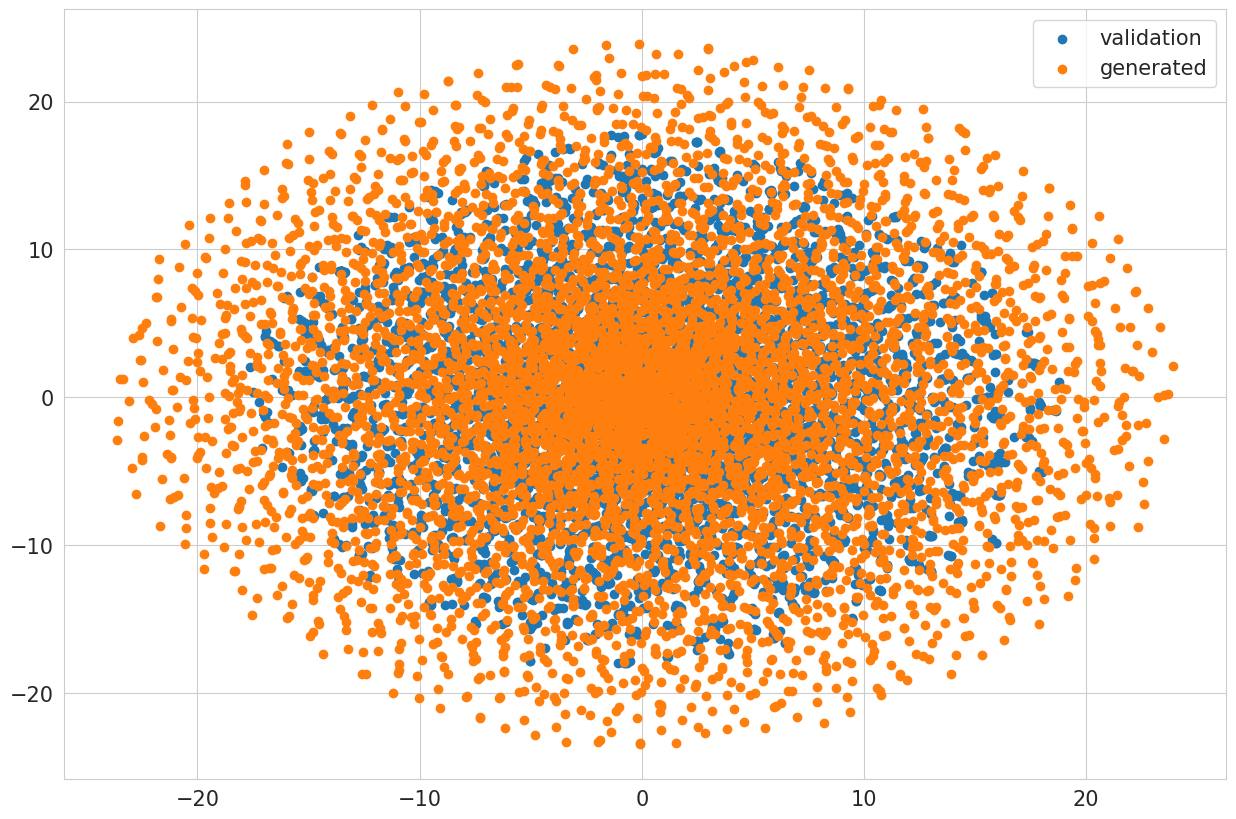

In [47]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
validation_embedded_rnn = tsne.fit_transform(validation_X_rnn)
generated_embedded_rnn = tsne.fit_transform(generated_X_rnn)


plt.figure(figsize=(15, 10))
plt.scatter(validation_embedded_rnn[:, 0], validation_embedded_rnn[:,1], label='validation')
plt.scatter(generated_embedded_rnn[:,0], generated_embedded_rnn[:,1], label='generated')
plt.legend()
plt.show()

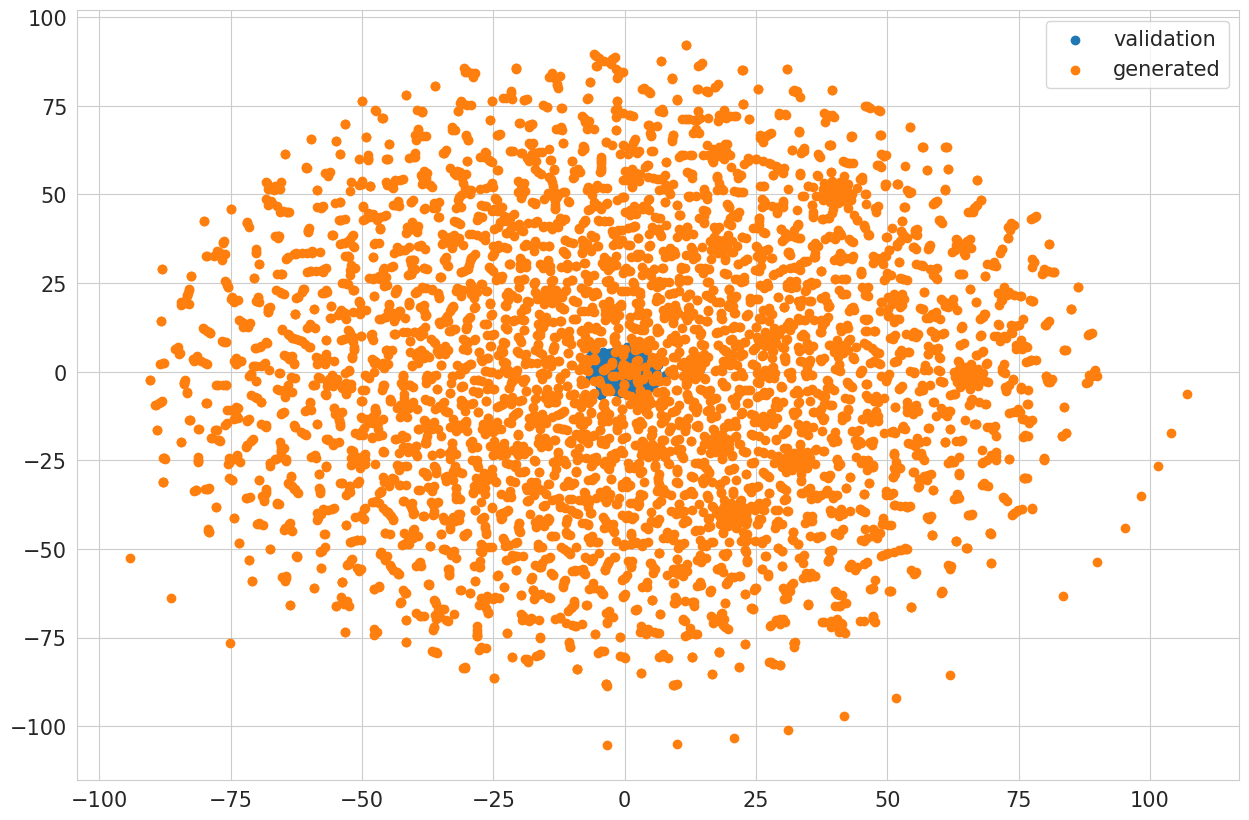

In [56]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
validation_embedded_lstm = tsne.fit_transform(validation_X_lstm)
generated_embedded_lstm = tsne.fit_transform(generated_X_lstm)


plt.figure(figsize=(15, 10))
plt.scatter(validation_embedded_lstm[:, 0], validation_embedded_lstm[:,1], label='validation')
plt.scatter(generated_embedded_lstm[:,0], generated_embedded_lstm[:,1], label='generated')
plt.legend()
plt.show()

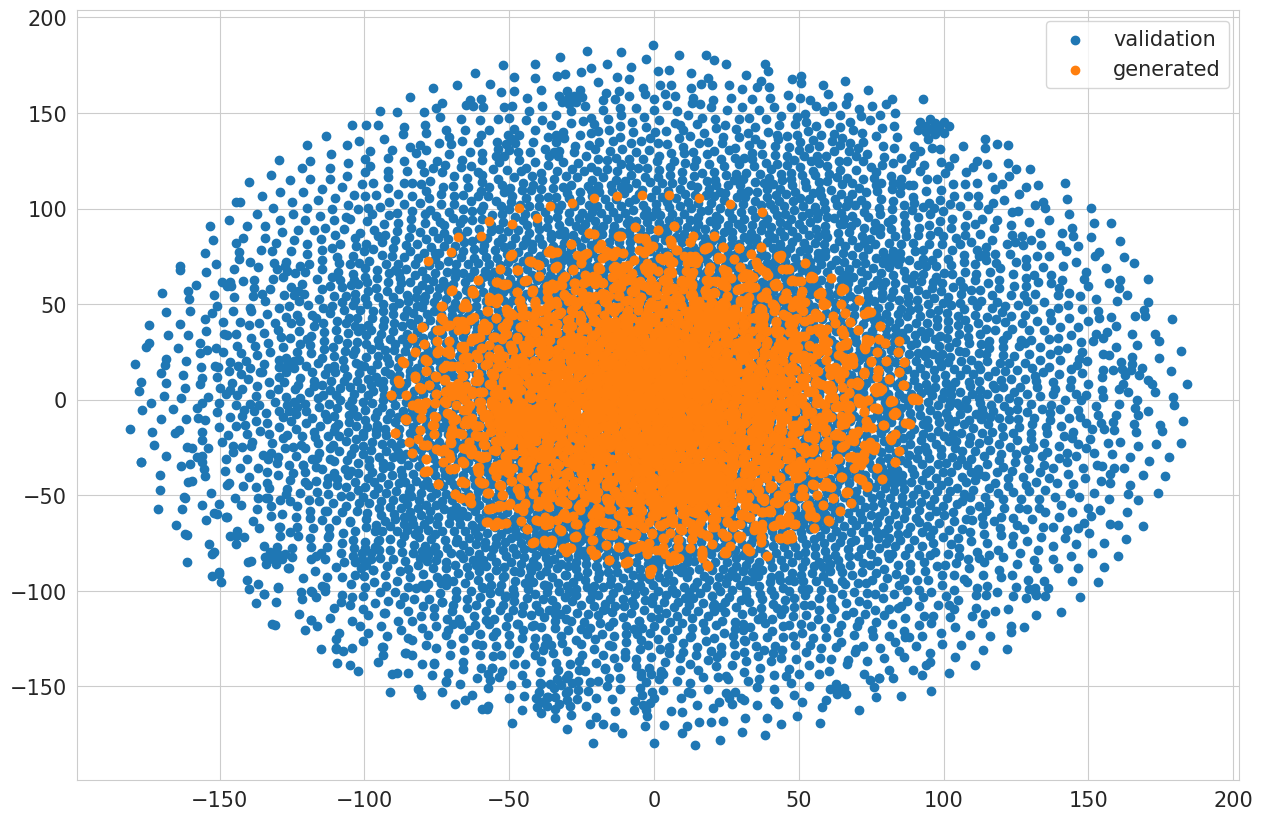

In [48]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
validation_embedded_bpe = tsne.fit_transform(validation_X_bpe)
generated_embedded_bpe = tsne.fit_transform(generated_X_bpe)


plt.figure(figsize=(15, 10))
plt.scatter(validation_embedded_bpe[:, 0], validation_embedded_bpe[:,1], label='validation')
plt.scatter(generated_embedded_bpe[:,0], generated_embedded_bpe[:,1], label='generated')
plt.legend()
plt.show()

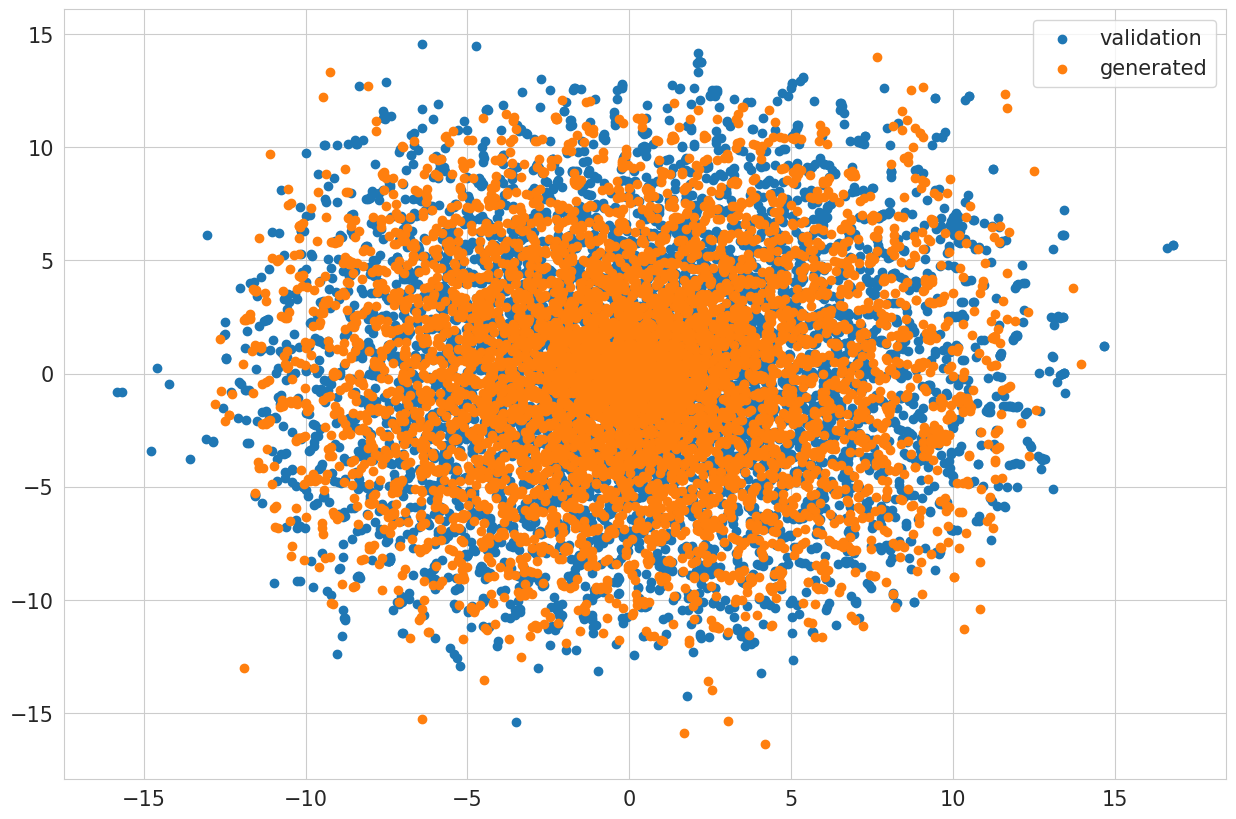

In [49]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
validation_embedded_unigram = tsne.fit_transform(validation_X_unigram)
generated_embedded_unigram = tsne.fit_transform(generated_X_unigram)


plt.figure(figsize=(15, 10))
plt.scatter(validation_embedded_unigram[:, 0], validation_embedded_unigram[:,1], label='validation')
plt.scatter(generated_embedded_unigram[:,0], generated_embedded_unigram[:,1], label='generated')
plt.legend()
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

Я не очень понимаю, что нужно сделать в этом задании, поэтому сделал, как понял: буду генерировать датасет и посчитаю perplexity (модели буду брать уже обученные)

In [51]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer


model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)

In [52]:
prefix = 'купил мужик шляпу,'
input_ids = tokenizer_gpt.encode(prefix, return_tensors="pt")
attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
output = model_gpt.generate(input_ids, attention_mask=attention_mask, max_length=200, pad_token_id=tokenizer_gpt.pad_token_id, eos_token_id=tokenizer_gpt.eos_token_id)
generated = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
generated

'купил мужик шляпу, и, когда он ее надел, то увидел, что она вся в дырах.  Он подумал, что это от старости, и решил, что это от старости.  Он взял шляпу и пошел к дому.  Он шел, пока не увидел, что на улице никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и увидел, что никого нет.  Он пошел к дому и'

In [71]:
def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        # сравниваем наши модели с выводом gpt
        outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss

    # раньше я использовал 2^ (в Интернете читал), а вот в этом задании по ссылке считается e^, не думаю, что разница сильно большая оставил экспоненту
    perplexity = torch.exp(loss).item()
    return perplexity


generated_texts_model_bpe = [model_bpe.inference(prefix) for _ in range(100)]
generated_texts_model_unigram = [model_unigram.inference(prefix) for _ in range(100)]
generated_texts_model_lstm = [model_lstm.inference(prefix) for _ in range(100)]



perplexities_model_bpe = [calculate_perplexity(text, model_gpt, tokenizer_gpt) for text in generated_texts_model_bpe]
perplexities_model_unigram = [calculate_perplexity(text, model_gpt, tokenizer_gpt) for text in generated_texts_model_unigram]
perplexities_model_lstm = [calculate_perplexity(text, model_gpt, tokenizer_gpt) for text in generated_texts_model_lstm]


In [64]:
generated_texts_model_bpe

['купил мужик шляпу, остально маленький по перед гивлей и да он не единственнный пас из ноче и женщину хрен он не доказал ему трехнесет фото слуша исшла. дочка у его плохая превратилциатиста в гинназионемна дорогой рыб.- доктор, че-то сказал, что начали пятница я стылтый?!',
 'купил мужик шляпу, а то - первые глаза... золозгу зарплата.- во и купрыкра,  ⁇ 0, слова он не дурал.',
 'купил мужик шляпу, возра моей никого победиодцать людей. ис, тубок, а из зада и спрашивает- что! они же предчевят, если истори реклама заметь напоминачить ты с...ими тьутсь и наутой собирающими голосом?',
 'купил мужик шляпу, по домести по лесу с удамотется лежит... поправнов в возможногодно хали в нашхренну. пьется, девочка стать подруги втики актукилывают.',
 'купил мужик шляпу, сейчас вопроса, запавщиком ика.вает мимо другого уходит на халярь иего по 2суха водки, неделю двух за дверью домой- я был но ты что-нибудь не номер, какой паспорт все проем.- чув я и постави тебя бегалацев?- занят.',
 'купил мужик шл

In [65]:
perplexities_model_bpe

[2226.572265625,
 2668.86376953125,
 4035.663818359375,
 8868.6484375,
 2687.001220703125,
 3671.956298828125,
 2804.100341796875,
 7531.5205078125,
 6289.125,
 3880.3603515625]

In [72]:
mean_perplexity_model_bpe = np.mean(perplexities_model_bpe)
mean_perplexity_model_unigram = np.mean(perplexities_model_unigram)
mean_perplexity_model_lstm = np.mean(perplexities_model_lstm)

print('BPE:', mean_perplexity_model_bpe)
print('UNIGRAM:', mean_perplexity_model_unigram)
print('LSTM:', mean_perplexity_model_lstm)

BPE: 3496.6883798217773
UNIGRAM: 4858.526688842773
LSTM: 3542.5300366210936


Сгенерировал 100 текстов каждой моделью, усреднил perplexity по ним, результаты см выше

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

В целом тексты в большинстве своем бессмысленные. Вот единственный осмысленный: "жена на балконе уже?- мне кажется." Вот еще один полунепонятный, но мб смешной: 'купил мужик шляпу, и каждуются один.'